# Hyperparameter optimization

After evaluating the performance of different modelling frameworks with baseline hyperparameters, the performance of the Gradiendt Boosting Classifier showed the highest accuracy score. Hence, we are proceeding with the Gradient Boosting Classifier (GBC), or the `sklearn` class `GradientBoostingClassifier()`.

### Gradient Boosting Classifier
#### What is Gradient Boosting?
Before we start examining the hyperparameters of the Gradient Boosting Classifier (`GradientBoostingClassifier()`), it would be a good idea to recap on what this classifier is. So what is GBC? According to [this source](https://medium.com/analytics-vidhya/introduction-to-gradient-boosting-classification-da4e81f54d3):

>Gradient Boosting is the grouping of gradient descent and boosting. In gradient boosting, each new model minimizes the loss function from its predecessor using the Gradient Descent Method. This procedure continues until a more optimal estimate of the target variable has been achieved.

GBC, therefore, is a sequential ensemble model - meaning that in order to achieve great accuracy, a number of models need to run. Importantly, this cannot be done in parallel (hence, 'sequential'). This is important to note, as GBCs can get computationally costly, especially in a large hyperparameter space.

#### Hyperparameters of GBC (and `GradientBoostingClassifier()`)
The Hyperparameters of GBC are quite neatly covered in the [previously-used source](https://medium.com/analytics-vidhya/introduction-to-gradient-boosting-classification-da4e81f54d3). Here is a brief overview of most important hyperparameters:

- **Learning rate**: by using gradient descent, this hyperparameter affects the speed of algorithm convergence. There is a tradeoff between the value size with smaller values minimizing overfitting (but taking more time until convergence) and larger values, while potentially not reaching an optimal fit, lead to a faster convergence.

- **Number of trees**: how many trees are optimal to minimize the loss function? 

- **Depth of trees**: the number of splitsin a tree.

- **Subsampling**: what is the proportion of trainig data used for training a tree? 

All this briefly summarized, let's start the analysis.

## Setup

In [1]:
# Install packages
#!pip install hyperopt
#!pip install git+https://github.com/hyperopt/hyperopt.git

In [3]:
# Libraries
## General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

## Model training and evaluation
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

## Classifiers
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

## Hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.pyll.stochastic

## Misc
from statsmodels.stats.contingency_tables import mcnemar # McNemar test
import warnings
warnings.filterwarnings("ignore")

# About FMIN: https://github.com/hyperopt/hyperopt/wiki/FMin

## Import the training and test data

In [5]:
train_df

,aluminium;ammonium;boron;chloride;coli-like-bacteria-colilert;coli-like-bacteria;colony-count-at-22-c;color-pt-co-unit;color-pt/co-scale;electrical-conductivity;enterococci;escherichia-coli-colilert;escherichia-coli;fluoride;iron;manganese;nitrate;nitrite;odour-dilution-level;oxidability;smell-ball-units;sodium;sulphate;taste-ball-units;taste-dilution-degree;turbidity-ntu;ph ;compliance
0,5.0;0.05;0.2;23.0;0.0;0.0;5.0;1.8;2.1;474.0;0....
1,5.0;0.05;0.2;23.0;0.0;0.0;0.0;5.0;0.0;465.0;0....
2,5.0;0.05;0.2;23.0;0.0;0.0;0.0;5.0;0.0;448.0;0....
3,5.0;0.09;0.641;23.0;0.0;0.0;15.0;5.0;4.0;978.0...
4,5.0;0.06;0.2;23.0;0.0;0.0;1.0;6.6;2.1;446.0;0....
...,...
875,5.0;0.05;0.2;23.0;0.0;0.0;3.0;5.0;3.0;622.0;0....
876,5.0;0.05;0.2;23.0;0.0;0.0;10.0;5.0;5.0;500.0;0...
877,5.0;0.27;0.274;14.0;0.0;0.0;66.0;5.0;6.0;596.0...
878,5.0;0.05;0.2;23.0;0.0;0.0;1.0;2.7;2.1;425.0;0....


In [6]:
train_df = pd.read_csv("/home/marilin/xAutoML-Project1/fjodor/project-1/data/clean/train_clean.csv", delimiter = ";")
test_df = pd.read_csv("/home/marilin/xAutoML-Project1/fjodor/project-1/data/clean/test_clean.csv", delimiter = ";")

X_train = train_df.iloc[:,:27]
y_train = train_df['compliance']

# Training and validation data
#X_train, X_val, y_train, y_val = train_test_split(train_df.iloc[:,:27], train_df['compliance_2020'], test_size=0.33, random_state=42)

# Test data
X_test = test_df.iloc[:,:27]
y_test = test_df['compliance']

print(f'X_train dims: {X_train.shape}')
print(f'y_train dims: {y_train.shape}')

#print(f'X_val dims: {X_val.shape}')
#print(f'y_val dims: {y_val.shape}')

print(f'X_test dims: {X_test.shape}')
print(f'y_test dims: {y_test.shape}')

X_train dims: (880, 27)
y_train dims: (880,)
X_test dims: (378, 27)
y_test dims: (378,)


## Hyperparameter optimization
A great resources for hyperparameter optimization using the `hyperopt`library can be found [here](https://medium.com/district-data-labs/parameter-tuning-with-hyperopt-faa86acdfdce).

Running the hyperparameter optimization.

In [7]:
names = [
    "Gradient Boosting Classifier",
    "LDA",
    "Random Forest",
    "AdaBoost",
    "Logistic Regression"
]

classifiers = [
    GradientBoostingClassifier(),
    LinearDiscriminantAnalysis(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    LogisticRegression() 
]

search_spaces = [
    
    # GBC
    {
        'learning_rate': hp.choice('learning_rate', np.arange(0.001, 0.4, 0.001)), # default=0.1
        'n_estimators': hp.choice('n_estimators', range(50, 250, 1)), # default=100
        'subsample': hp.choice('subsample', np.arange(0.01, 1, 0.01)), # default=1.0
        'max_depth': hp.choice('max_depth', range(1,20)), # default=3
        'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2']), # default=None
     #   'criterion': hp.choice('criterion', ["friedman_mse", "squared_error"]) # default=’friedman_mse’
    },
    
    # LDA
    {
        'solver': hp.choice('solver', ['lsqr', 'eigen']), # default=’svd’
        'shrinkage': hp.choice('shrinkage', np.arange(0.01, 1, 0.01)), # default=None # not supported with 'svd' solver
        
    },
    
    # RF
    {
        'n_estimators': hp.choice('n_estimators', range(50, 250, 1)), # default=100
        'min_samples_split': hp.choice('min_samples_split', range(2, 7, 1)), # default=2
        'max_features': hp.choice('max_features', ['sqrt', 'log2']), # default='sqrt'
    },
    
    # AdaBoost
    {
        'learning_rate': hp.choice('learning_rate', np.arange(0.001, 0.4, 0.001)), # default=1.0
        'n_estimators': hp.choice('n_estimators', range(50, 250, 1)), # default=100
        
    },
    
    # Logistic Regression
    { 
        'penalty': hp.choice('penalty', ['l1', 'l2', 'elasticnet', 'none']), # default=’l2’
        'l1_ratio': hp.choice('l1_ratio', np.arange(0.01, 1, 0.01)),
        'C': hp.choice('C', np.arange(0.01, 1, 0.01)), # default = 1.0
        'solver': 'saga' # # use solver = 'saga' for using different penalties
    }   
]

In [ ]:
# Initialize a dataframe for results collection
model_results = pd.DataFrame(columns = ['classifier', 'best_cv_score', 'runtime_hpo', 'best_params', 'test_acc'])
model_results.head()

# Run the HPO and get the best params for each classifier
for i in range(len(classifiers)):
    
    print()
    print(f'Using the *{names[i]}* for estimation.')
    
    def hyperopt_cv_score(params):
        cv = RepeatedKFold(n_splits=5, n_repeats=5)
        model = classifiers[i].set_params(**params) # use the classifier from the list
        return cross_val_score(model, 
                               X_train, y_train, 
                               cv = cv,  
                               scoring = 'accuracy',
                               error_score='raise').mean() #np.mean(gbc.predict(X_test) == y_test)

    def f(params):
        global best_cv_score
        global best_params
        global best_time
        cv_score = hyperopt_cv_score(params)
        if cv_score > best_cv_score:
            best_cv_score = cv_score # what is the best score?
            best_params = params # what are the best params?
            best_time = round(time.time() - start_time,4) # track how much time it took to find the best params
            print('new best:', best_cv_score, best_params)
        return {'loss': -cv_score, # see the comment below
                'status': STATUS_OK}
        # Comment regarding 'negative accuracy' (from the referenced source):
        ## Since we are trying to maximize the accuracy (acc in the code above), 
        ## we must negate this value for hyperopt, since hyperopt only knows how to minimize a function. 
        ## Minimizing a function f is the same as maximizing the negative of f.

    best_cv_score = 0
    best_params = None
    best_time = 0
    trials = Trials() # store info at each step
    
    # Start running the algorithm and track time
    start_time = time.time()
    best = fmin(f, 
                search_spaces[i], # use the search space associated with the classifier
                algo = tpe.suggest, 
                max_evals = 100, # how many evaluations?
                trials = trials)
    
    # save trials
    
    
    # Compute the accuracy score on the best model of the classifier
    m = classifiers[i].set_params(**best_params).fit(X_train, y_train)
    score_test = m.score(X_test, y_test)
    
    
    # Append the best results to the df
    model_results = model_results.append({'classifier': names[i], 
                             'best_cv_score': best_cv_score, 
                             'runtime_hpo': best_time, 
                             'best_params': best_params,
                             'test_acc': score_test}, ignore_index = True)

# Sort the model results by test accuracy score and then Runtime
model_results = model_results.sort_values(['test_acc', 'runtime_hpo'], ascending = [0,1]).reset_index(drop = True)


Using the *Gradient Boosting Classifier* for estimation.
new best:                                                                                                
0.93                                                                                                     
{'learning_rate': 0.382, 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 69, 'subsample': 0.3}   
new best:                                                                                                
0.9738636363636364                                                                                       
{'learning_rate': 0.08, 'max_depth': 14, 'max_features': 'auto', 'n_estimators': 79, 'subsample': 0.32}  
new best:                                                                                                
0.9740909090909091                                                                                       
{'learning_rate': 0.177, 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 59, 'subsampl

new best:                                                                                                
0.9845454545454545                                                                                       
{'learning_rate': 0.275, 'n_estimators': 163}                                                            
 94%|██████████████████████████████  | 94/100 [09:58<00:39,  6.60s/trial, best loss: -0.9845454545454545]

Let's look at the results:

In [ ]:
model_results

Let's plot the model test set accuracy against runtime.

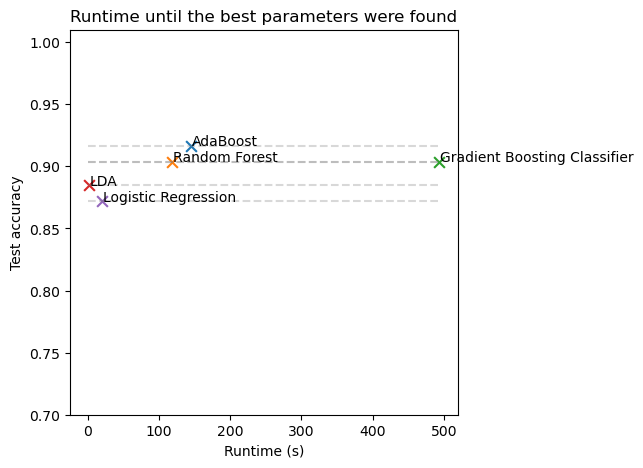

In [7]:
plt.figure(figsize = [5, 5])

for i in range(len(model_results)):
    # Add classifier values
    plt.scatter(model_results['runtime_hpo'][i], 
            model_results['test_acc'][i], 
            label = model_results['classifier'][i],
               marker = 'x',
               s = 60)
    # Add a dashed lined marking the best accuracy threshold for classifier
    plt.hlines(y = model_results['test_acc'][i], 
               xmin=0, 
               xmax = np.max(model_results['runtime_hpo'])+1,
              linestyles = 'dashed', alpha = 0.3, color = 'grey')
    # Add classifier name
    plt.annotate(model_results['classifier'][i], 
                 (model_results['runtime_hpo'][i]+1, 
                  model_results['test_acc'][i]),
                )
plt.ylim(bottom = 0.70, top = 1.01)
plt.xlabel('Runtime (s)')
plt.ylabel('Test accuracy')
plt.title('Runtime until the best parameters were found')
plt.show();

Let's plot the accuracy values over each iteration with the baseline accuracy as the reference point.

Let's plot the values of parameters and accuracy

In [8]:
# Plot for parameters
## Tutorial: https://medium.com/district-data-labs/parameter-tuning-with-hyperopt-faa86acdfdce
#parameters = ['learning_rate', 'n_estimators',
#              'subsample', 'max_depth', 
#              'max_features', 'criterion']

#f, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,5))
#f.tight_layout()
#cmap = plt.cm.jet
#for i, val in enumerate(parameters):
#    # print (i, val)
#    # Getting the hyperparameter and loss values with list comprehension
#    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
#    ys = [-t['result']['loss'] for t in trials.trials]
#    # Making the necessary sorting
#    xs, ys =  zip(*sorted(zip(xs, ys)))
#    ys = np.array(ys)
#    # Plot
#    axes[int(i/3),int(i%3)].scatter(xs, ys, 
#                          s=20, 
#                          linewidth=0.01, 
#                         # alpha= 0.5,
#                          color=cmap(float(i)/len(parameters))
#                                   )
#    axes[int(i/3),int(i%3)].set_title(val)
#    axes[int(i/3),int(i%3)].set_ylim([0.2,1.0])
#    
#plt.show();

## Experimenting with `hyperopt-sklearn`
Above, we provided the definition for the search space. Hoqever, `hyperopt` can also function without explicitly specifying the search space - enter `hyperopt-sklearn`, a presently developed library (see [here](https://github.com/hyperopt/hyperopt-sklearn) that provides more automation for hyperparameter optimization. 

Below we will run the classifier used above without specified search space. Of note, this might mean that some models will not compute or converge, since some hyperparameter combinations do not work together. In those cases, we just skip the hyperparameter combination and proceed.

The advantages is that we can reduce manual work in specifying hyperparameter space for each classifier. The main disadvantage is that some of the pereviously-used functions are not easily programmable here, i.e., the `hypropt-sklearn` is somewhat less flexible.

In [9]:
# !pip install git+https://github.com/hyperopt/hyperopt-sklearn
from hpsklearn import HyperoptEstimator, gradient_boosting_classifier, ada_boost_classifier, random_forest_classifier, logistic_regression, linear_discriminant_analysis

In [10]:
# 1. Initialize a dataframe
model_results_auto = pd.DataFrame(columns = ['classifier', 'test_acc', 'best_params'])

# 2. Classifier labels
names_auto = [
    "Gradient Boosting Classifier",
    "LDA",
    "Random Forest",
    "AdaBoost",
    "Logistic Regression"
]

# 3. Classifier classes
classifiers_auto = [
    gradient_boosting_classifier("gbc"),
    linear_discriminant_analysis('lda'),
    random_forest_classifier('rf'), 
    ada_boost_classifier('ada'), 
    logistic_regression('logreg')
]

# 4. Iterate over all classifiers
for i in range(len(classifiers_auto)):
    print()
    print(f'Using the *{names_auto[i]}* for estimation.')
    
    # Objective function
    estim = HyperoptEstimator(classifier = classifiers_auto[i],
                                    #  preprocessing=[],
                                      algo=tpe.suggest,
                                      max_evals=100)
    try:
        # Fit the model
        estim.fit(X_train, y_train)
        
        # Add the results to df
        model_results_auto = model_results_auto.append(
            {'classifier': names_auto[i], 
            # 'runtime_hpo': best_time,
             'test_acc': estim.score(X_test, y_test),
             'best_params': estim.best_model()
             }, 
            ignore_index = True)
    except:
        print('Model with params not computed')
        # Append the name but assign None-values to fields
        model_results_auto = model_results_auto.append(
            {'classifier': names_auto[i], 
            # 'runtime_hpo': best_time,
             'test_acc': None,
             'best_params': None
             }, 
            ignore_index = True)

model_results_auto = model_results_auto.sort_values(['test_acc'], ascending = False).reset_index(drop = True)


Using the *Gradient Boosting Classifier* for estimation.
 50%|██████████████████▌                  | 1/2 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


 75%|███████████████████████████▊         | 3/4 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


 80%|█████████████████████████████▌       | 4/5 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


 83%|██████████████████████████████▊      | 5/6 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


 88%|████████████████████████████████▍    | 7/8 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


 89%|████████████████████████████████▉    | 8/9 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


 91%|███████████████████████████████▊   | 10/11 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


 92%|████████████████████████████████   | 11/12 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


 93%|████████████████████████████████▌  | 13/14 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


 94%|████████████████████████████████▉  | 16/17 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


 94%|█████████████████████████████████  | 17/18 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


 95%|█████████████████████████████████▎ | 20/21 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


 98%|██████████████████████████████████▏| 42/43 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


 98%|██████████████████████████████████▏| 44/45 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


 98%|██████████████████████████████████▎| 47/48 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


 98%|██████████████████████████████████▎| 49/50 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


 98%|██████████████████████████████████▎| 52/53 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


 98%|██████████████████████████████████▍| 55/56 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


 98%|██████████████████████████████████▍| 59/60 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


 98%|██████████████████████████████████▍| 63/64 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


 99%|██████████████████████████████████▌| 80/81 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


 99%|██████████████████████████████████▌| 84/85 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


 99%|██████████████████████████████████▌| 89/90 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


 99%|██████████████████████████████████▋| 93/94 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


 99%|██████████████████████████████████▋| 98/99 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


 99%|█████████████████████████████████▋| 99/100 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


100%|███████| 100/100 [00:01<00:00,  1.13s/trial, best loss: 0.0641025641025641]

Using the *LDA* for estimation.
  0%|                                     | 0/1 [00:00<?, ?trial/s, best loss=?]

job exception: The leading minor of order 14 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.



  0%|                                     | 0/1 [00:01<?, ?trial/s, best loss=?]
Model with params not computed

Using the *Random Forest* for estimation.
100%|██████| 100/100 [00:01<00:00,  1.15s/trial, best loss: 0.08974358974358976]

Using the *AdaBoost* for estimation.
 99%|██████████████████████████████████▌| 86/87 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)


 99%|██████████████████████████████████▌| 89/90 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_weight_boosting.py:676: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 8, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)


 99%|██████████████████████████████████▌| 90/91 [00:00<?, ?trial/s, best loss=?]

/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_weight_boosting.py:675: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/Users/drdr/opt/anaconda3/envs/automl_2022/lib/python3.8/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 2, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)


100%|██████| 100/100 [00:01<00:00,  1.12s/trial, best loss: 0.07692307692307687]

Using the *Logistic Regression* for estimation.
100%|██████| 100/100 [00:01<00:00,  1.10s/trial, best loss: 0.07692307692307687]


Look at the results table:

In [11]:
model_results_auto

,classifier,test_acc,best_params
0,Gradient Boosting Classifier,0.897436,{'learner': ([DecisionTreeRegressor(criterion=...
1,Logistic Regression,0.897436,{'learner': LogisticRegression(C=1.62874169142...
2,AdaBoost,0.891026,{'learner': (DecisionTreeClassifier(max_depth=...
3,Random Forest,0.878205,{'learner': (DecisionTreeClassifier(criterion=...
4,LDA,NaN,None


# Significance testing 
In the below section, we will test whether the differences between the models are statistically significant. For that, we will use pairwise McNemar test to compare each model with each other. P-values have the continuity correction.

We first start by defining the helper function for the pairwise McNemar test.

In [86]:
# McNemar test for practice sessions/homeworks into a function
def mcnemar_test(ground_truth, preds1, preds2):
    """Get the McNemar test results for comparison between two models
    Args: 
        ground_truth (np.array): the ground truth, an np.array (usually y_test)
        preds1 (np.array): predictions from Model 1
        preds2 (np.array): predictions from Model 2
    Returns:
        statistic (float): McNemar statistic
        pvalue (float): p-value of the significance test
    """
    
    ## Create the prediction data set
    mc_data = pd.DataFrame()
    mc_data["ground_truth"] = y_test.tolist()
    mc_data["y_pred1"] = preds1.tolist()
    mc_data["y_pred2"] = preds2.tolist()
    # mc_data.head(5)

    ## Create the contingency table
    mc_data.loc[mc_data['ground_truth']==mc_data['y_pred1'],'correct_pred1']="Yes"
    mc_data.loc[mc_data['ground_truth']!=mc_data['y_pred1'],'correct_pred1']="No"
    mc_data.loc[mc_data['ground_truth']==mc_data['y_pred2'],'correct_pred2']="Yes"
    mc_data.loc[mc_data['ground_truth']!=mc_data['y_pred2'],'correct_pred2']="No"

    contingency_table_df=pd.DataFrame(data={"nr_correct_pred1":["Yes/Yes","No/Yes"], 
                                            "nr_incorrect_pred1":["Yes/No","No/No"]}, 
                                      index=["nr_correct_pred2","nr_incorrect_pred2"])

    ## Add the numbers to contingency tables
    nr_corr_pred2_corr_pred1=0
    nr_corr_pred2_incorr_pred1=0
    nr_incorr_pred2_corr_pred1=0
    nr_incorr_pred2_incorr_pred1=0
    for index, row in mc_data.iterrows():
        if  row['correct_pred2']== "Yes" and  row['correct_pred1']=="Yes":
            nr_corr_pred2_corr_pred1+=1
        elif row['correct_pred2']== "Yes" and  row['correct_pred1']=="No":
            nr_corr_pred2_incorr_pred1+=1
        elif row['correct_pred2']== "No" and  row['correct_pred1']=="Yes":
            nr_incorr_pred2_corr_pred1+=1
        elif row['correct_pred2']== "No" and  row['correct_pred1']=="No":
            nr_incorr_pred2_incorr_pred1+=1

    contingency_table_df.iloc[0,0]=nr_corr_pred2_corr_pred1
    contingency_table_df.iloc[0,1]=nr_corr_pred2_incorr_pred1
    contingency_table_df.iloc[1,0]=nr_incorr_pred2_corr_pred1
    contingency_table_df.iloc[1,1]=nr_incorr_pred2_incorr_pred1

    # Calculate The McNemar test statistic and p-value
    mc_results = mcnemar(contingency_table_df, exact=False, correction=True)
    return mc_results

Next, we iterate over all models and compare their performance against all other models.

In [138]:
# Find the classifier
df_sig = pd.DataFrame(columns = ['model1', 'model2', 'mc_stat', 'pvalue_adj'])

## Ground truth
ground_truth = y_test

comparisons = []

for i in range(len(model_results)):
    for j in range(len(model_results)-1):
        # Names of models
        name1 = model_results['classifier'][i]
        name2 = model_results['classifier'][j+1]
        
        if name1 == name2: # no point in comparing the model with self
            pass
        else:
            comparison = list(set((name1, name2))) # no point in duplicating comparisons
        
            if comparison not in comparisons:
                comparisons.append(comparison)
                
                # Model 1
                idx1 = int(np.where(np.array(names) == name1)[0])
                classifier1 = classifiers[idx1]
                best_params1 = model_results['best_params'][i]
                best_model1 = classifier1.set_params(**best_params1).fit(X_train, y_train)
                preds1 = best_model1.predict(X_test)

                ## Model 2
                idx2 = int(np.where(np.array(names) == model_results['classifier'][j+1])[0])
                classifier2 = classifiers[idx2]
                best_params2 = model_results['best_params'][j+1]
                best_model2 = classifier2.set_params(**best_params2).fit(X_train, y_train)
                preds2 = best_model2.predict(X_test)

                # McNemar test
                mc = mcnemar_test(ground_truth, preds1, preds2)
                pvalue, statistic = mc.pvalue, mc.statistic
                
                # Append to the dataframe
                df_sig = df_sig.append({'model1': name1, 
                               'model2': name2, 
                               'mc_stat': statistic, 
                               'pvalue_adj': pvalue}, ignore_index = True)
            else:
                pass


Let's look at the pairwise differences table. Just a reminder that p-values have the continuity correction.

In [139]:
df_sig

,model1,model2,mc_stat,pvalue_adj
0,AdaBoost,Random Forest,140.007042,2.652612e-32
1,AdaBoost,Gradient Boosting Classifier,137.007194,1.201490e-31
2,AdaBoost,LDA,135.007299,3.289573e-31
3,AdaBoost,Logistic Regression,131.007519,2.466702e-30
4,Random Forest,Gradient Boosting Classifier,134.007353,5.443351e-31
5,Random Forest,LDA,135.007299,3.289573e-31
6,Random Forest,Logistic Regression,130.007576,4.082167e-30
7,Gradient Boosting Classifier,LDA,129.007634,6.755805e-30
8,Gradient Boosting Classifier,Logistic Regression,129.007634,6.755805e-30
9,LDA,Logistic Regression,130.007576,4.082167e-30


<font color= 'red'> Something's probably not right here. RF and GBC have the same test accuracy yet they are different here... </font>